In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
epochs_per_batch = 500

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=10000000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all[df_all['time'] <= epochs_per_batch * time_epoch]

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [2]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all[df_all['time'] <= epochs_per_batch * time_epoch / 5]['source computer'].values))) 

In [3]:
from helper import group_scale_data, group_scale_data_batch

def get_data(df_all, ranges=range(10), time_epoch=60, epochs_per_batch=50, hosts=None):
    frames = []
    for time in ranges:
        print('Starting time', time)
        
        tempdf = df_all[(df_all['time'] > epochs_per_batch * time_epoch * time) &
                        (df_all['time'] <= epochs_per_batch * time_epoch * (time + 1))]
        tempdf.index = tempdf['time']
        tempdf.drop(columns=['time'],inplace=True)
        
        groupped_data, hosts, parameters = group_scale_data(tempdf, size_of_bin_seconds=time_epoch,
                                                            addZeros=True, doScale=True, scaler='log', verbose=0, hosts=hosts)
        groupped_data['epoch'] += time * epochs_per_batch
        frames.append(groupped_data)
        
    return pd.concat(frames), hosts, parameters

In [7]:
groupped_data, hosts, parameters = get_data(df_all, ranges=range(10), hosts=hosts)

Starting time 0


c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Starting time 1
Starting time 2
Starting time 3
Starting time 4
Starting time 5
Starting time 6
Starting time 7
Starting time 8
Starting time 9


In [10]:
groupped_data1, hosts, parameters = get_data(df_all, ranges=range(10,20), hosts=hosts)

Starting time 10


c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Starting time 11
Starting time 12
Starting time 13
Starting time 14
Starting time 15
Starting time 16
Starting time 17
Starting time 18
Starting time 19


In [11]:
len(groupped_data1) / len(hosts)

500.0

In [37]:
print(len(hosts))
print(len(set(groupped_data['source computer'])))

1894
5563


In [4]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np
import pandas as pd

In [2]:
from sklearn.externals import joblib

#joblib.dump(groupped_data,'groupped_data_60_500.pkl')
#joblib.dump(groupped_data1,'groupped_data1_60_500.pkl')
groupped_data = joblib.load('groupped_data_60_500.pkl')
groupped_data1 = joblib.load('groupped_data1_60_500.pkl')

In [3]:
#joblib.dump(hosts,'hosts_60_500.pkl')
hosts = joblib.load('hosts_60_500.pkl')

### Pooled Poisson

In [14]:
data = groupped_data.values[:, :2]
data1 = groupped_data1.values[:, :2]

In [15]:
lambdas = np.mean(data, axis=0)

In [16]:
import scipy.stats.distributions
from math import log

def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

def likelihood(lambdas, data):
    likelihood = 0
    intervals = len(data) / 20
    for i, x in enumerate(data):
        if i % intervals == 0:
            print('Done with', int(i/intervals),'/',20)
        total_x = poisson(x, lambdas)
        likelihood = likelihood + log(total_x)
    return likelihood/len(data)

In [17]:
likelihood(lambdas, data)

Done with 0 / 20
Done with 1 / 20
Done with 2 / 20
Done with 3 / 20
Done with 4 / 20
Done with 5 / 20
Done with 6 / 20
Done with 7 / 20
Done with 8 / 20
Done with 9 / 20
Done with 10 / 20
Done with 11 / 20
Done with 12 / 20
Done with 13 / 20
Done with 14 / 20
Done with 15 / 20
Done with 16 / 20
Done with 17 / 20
Done with 18 / 20
Done with 19 / 20


-16.694797327938353

In [18]:
likelihood(lambdas, data1)

Done with 0 / 20
Done with 1 / 20
Done with 2 / 20
Done with 3 / 20
Done with 4 / 20
Done with 5 / 20
Done with 6 / 20
Done with 7 / 20
Done with 8 / 20
Done with 9 / 20
Done with 10 / 20
Done with 11 / 20
Done with 12 / 20
Done with 13 / 20
Done with 14 / 20
Done with 15 / 20
Done with 16 / 20
Done with 17 / 20
Done with 18 / 20
Done with 19 / 20


-17.225664226501785

### Pooled Mixture of Poissons

In [64]:
mixtures = 13

kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)


Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7
Centers found: 8
Centers found: 9
Centers found: 10
Centers found: 11
Centers found: 12
Centers found: 13


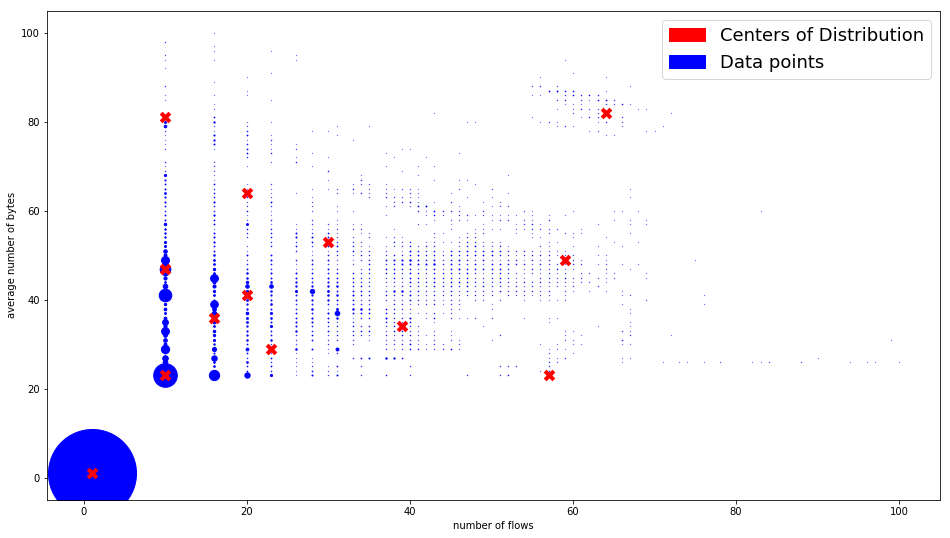

In [65]:
test = int(len(set(groupped_data['source computer'].values)))

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, test, n_clusters=8, verbose=1, update_power=0.5)

plot_points(groupped_data.values[:, :2], onlineEM)

In [66]:
data = groupped_data.values[:,[0,1,3]]

onlineEM.fit(data)

Running for data till position 1912 from total 191200
Running for data till position 3824 from total 191200
Running for data till position 5736 from total 191200
Running for data till position 7648 from total 191200
Running for data till position 9560 from total 191200
Running for data till position 11472 from total 191200
Running for data till position 13384 from total 191200
Running for data till position 15296 from total 191200
Running for data till position 17208 from total 191200
Running for data till position 19120 from total 191200
Running for data till position 21032 from total 191200
Running for data till position 22944 from total 191200
Running for data till position 24856 from total 191200
Running for data till position 26768 from total 191200
Running for data till position 28680 from total 191200
Running for data till position 30592 from total 191200
Running for data till position 32504 from total 191200
Running for data till position 34416 from total 191200
Running for dat

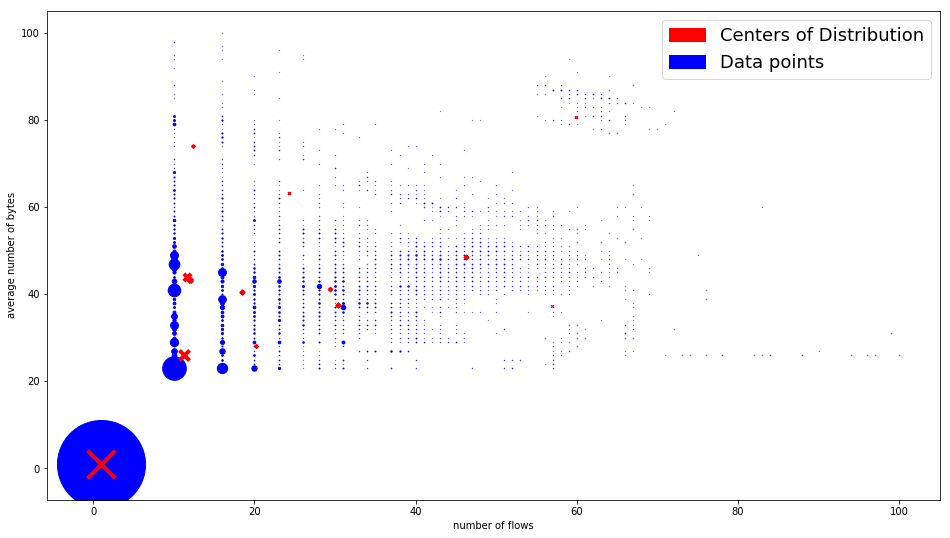

In [68]:
plot_points(groupped_data.values[:, :2], onlineEM)

In [30]:
# joblib.dump(onlineEM,'onlineEM_60_100_13.pkl')
onlineEM = joblib.load('onlineEM_60_100_13.pkl')

In [31]:
data1 = groupped_data1.values[:,[0,1,3]]

onlineEM.calculate_likelihood(data1) / len(data1)

-4.107553895937868

### Per host mixture of Poissons

In [25]:
def likelihood_mixture_per_host(mixtures=3, groupped_data_train=groupped_data, groupped_data_test=groupped_data1):
    likelihoods = []
    likelihoods_for_hosts = []
    intervals = 100

    for i, host in enumerate(hosts):

        data_for_host_train = groupped_data_train[groupped_data_train['source computer'] == host]
        data_for_host_test = groupped_data_test[groupped_data_test['source computer'] == host]

        try:
            kplusplus = KPlusPlus(mixtures, data_for_host_train.values[:, :2], stochastic=False)

            kplusplus.init_centers(verbose=0)


            onlineEM_host = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, 50, n_clusters=1, verbose=0, update_power=0.5)

            onlineEM_host.fit(data_for_host_train.values[:,[0,1,3]])

            """
            plot_points(data_for_host.values[:, :2], onlineEM_host)
            print('kplusplus', kplusplus.centers)
            print(onlineEM_host.lambdas)
            print(onlineEM_host.gammas)
            """
            likelihoods.append(onlineEM_host.calculate_likelihood(data_for_host_test.values[:,[0,1,3]]) / len(data_for_host_test))
            likelihoods_for_hosts.append(host)
        except IndexError:
            pass

        if i% intervals == 0:
            print('Done with', i)

    return likelihoods, likelihoods_for_hosts

In [26]:
likelihoods_3, likelihoods_for_hosts_3 = likelihood_mixture_per_host(mixtures=3)

Done with 0
Done with 100
Done with 200
Done with 300
Done with 400
Done with 500
Done with 600
Done with 700
Done with 800
Done with 900
Done with 1000
Done with 1100


D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\kplusplus.py:57: RuntimeWarning: invalid value encountered in true_divide
  self.probabilities = self.distances / self.distances.sum()
D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\kplusplus.py:60: RuntimeWarning: invalid value encountered in greater_equal
  ind = np.where(self.cumulativeProbabilities >= r)[0][0]


Done with 1200
Done with 1300
Done with 1400
Done with 1500
Done with 1600
Done with 1700
Done with 1800


In [27]:
sum(likelihoods_3) / len(likelihoods_3)

-3.8904821673128946

In [28]:
joblib.dump(likelihoods_3,'likelihoods_3.pkl')
joblib.dump(likelihoods_for_hosts_3,'likelihoods_for_hosts_3.pkl')

['likelihoods_for_hosts_3.pkl']

In [59]:
def likelihoods_non_zero(likelihoods, percentages, least_percentage):
    
    result_likelihoods = []
    
    for i, per in enumerate(percentages):
        
        if per >= least_percentage:
            result_likelihoods.append(likelihoods[i])
    
    print('A total of', len(result_likelihoods), 'hosts satisfy the criteria')
    return sum(result_likelihoods) / len(result_likelihoods)

In [52]:
def calculate_percentages(groupped_data, hosts):
    percentages = []
    epochs = len(set(groupped_data['epoch'].values))
    for host in hosts:
        test = groupped_data[groupped_data['source computer'] == host]
        non_zero = len(test[test['number of flows'] > 1])
        
        percentages.append(non_zero/epochs)
    return np.array(percentages)

percentages = calculate_percentages(groupped_data, likelihoods_for_hosts_3)

In [66]:
for i in np.arange(0, 1, 0.1):
    print('For percentage', i, 'likelihood is', likelihoods_non_zero(likelihoods_3, percentages, i))

A total of 1893 hosts satisfy the criteria
For percentage 0.0 likelihood is -3.8904821673128946
A total of 1489 hosts satisfy the criteria
For percentage 0.1 likelihood is -4.097219943727841
A total of 681 hosts satisfy the criteria
For percentage 0.2 likelihood is -5.10467065912003
A total of 518 hosts satisfy the criteria
For percentage 0.3 likelihood is -5.3782310925109496
A total of 296 hosts satisfy the criteria
For percentage 0.4 likelihood is -5.8996082766689595
A total of 230 hosts satisfy the criteria
For percentage 0.5 likelihood is -6.076545875813595
A total of 157 hosts satisfy the criteria
For percentage 0.6 likelihood is -6.408701573089469
A total of 127 hosts satisfy the criteria
For percentage 0.7 likelihood is -6.618488698865063
A total of 93 hosts satisfy the criteria
For percentage 0.8 likelihood is -6.934728204629115
A total of 65 hosts satisfy the criteria
For percentage 0.9 likelihood is -7.2397230929516265


In [ ]:
for host in hosts:
    test = groupped_data[groupped_data['source computer'] == host]
    non_zero = len(test[test['number of flows'] > 1])
    
    test1 = groupped_data1[groupped_data1['source computer'] == host]
    non_zero1 = len(test1[test1['number of flows'] > 1])
    
    print('For host', host, 'groupped_data' , non_zero, 'test', non_zero1)

### Pooled data hmm

In [53]:
mixtures = 13

kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7
Centers found: 8
Centers found: 9
Centers found: 10
Centers found: 11
Centers found: 12
Centers found: 13


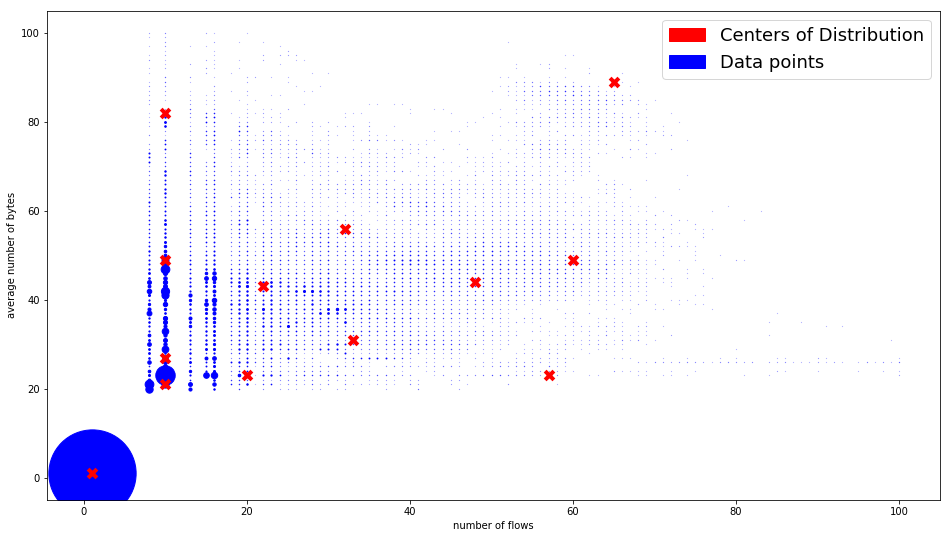

In [58]:
test = int(len(set(groupped_data['source computer'].values)))

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, test, n_clusters=8, verbose=1, update_power=0.5)

plot_points(groupped_data.values[:, :2], onlineEM)

In [59]:
data = groupped_data.values[:,[0,1,3]]

onlineEM.fit(data)

Running for data till position 1894 from total 947000
Running for data till position 3788 from total 947000
Running for data till position 5682 from total 947000
Running for data till position 7576 from total 947000
Running for data till position 9470 from total 947000
Running for data till position 11364 from total 947000
Running for data till position 13258 from total 947000
Running for data till position 15152 from total 947000
Running for data till position 17046 from total 947000
Running for data till position 18940 from total 947000
Running for data till position 20834 from total 947000
Running for data till position 22728 from total 947000
Running for data till position 24622 from total 947000
Running for data till position 26516 from total 947000
Running for data till position 28410 from total 947000
Running for data till position 30304 from total 947000
Running for data till position 32198 from total 947000
Running for data till position 34092 from total 947000
Running for dat

Running for data till position 282206 from total 947000
Running for data till position 284100 from total 947000
Running for data till position 285994 from total 947000
Running for data till position 287888 from total 947000
Running for data till position 289782 from total 947000
Running for data till position 291676 from total 947000
Running for data till position 293570 from total 947000
Running for data till position 295464 from total 947000
Running for data till position 297358 from total 947000
Running for data till position 299252 from total 947000
Running for data till position 301146 from total 947000
Running for data till position 303040 from total 947000
Running for data till position 304934 from total 947000
Running for data till position 306828 from total 947000
Running for data till position 308722 from total 947000
Running for data till position 310616 from total 947000
Running for data till position 312510 from total 947000
Running for data till position 314404 from total

Running for data till position 560624 from total 947000
Running for data till position 562518 from total 947000
Running for data till position 564412 from total 947000
Running for data till position 566306 from total 947000
Running for data till position 568200 from total 947000
Running for data till position 570094 from total 947000
Running for data till position 571988 from total 947000
Running for data till position 573882 from total 947000
Running for data till position 575776 from total 947000
Running for data till position 577670 from total 947000
Running for data till position 579564 from total 947000
Running for data till position 581458 from total 947000
Running for data till position 583352 from total 947000
Running for data till position 585246 from total 947000
Running for data till position 587140 from total 947000
Running for data till position 589034 from total 947000
Running for data till position 590928 from total 947000
Running for data till position 592822 from total

Running for data till position 839042 from total 947000
Running for data till position 840936 from total 947000
Running for data till position 842830 from total 947000
Running for data till position 844724 from total 947000
Running for data till position 846618 from total 947000
Running for data till position 848512 from total 947000
Running for data till position 850406 from total 947000
Running for data till position 852300 from total 947000
Running for data till position 854194 from total 947000
Running for data till position 856088 from total 947000
Running for data till position 857982 from total 947000
Running for data till position 859876 from total 947000
Running for data till position 861770 from total 947000
Running for data till position 863664 from total 947000
Running for data till position 865558 from total 947000
Running for data till position 867452 from total 947000
Running for data till position 869346 from total 947000
Running for data till position 871240 from total

In [62]:
# joblib.dump(onlineEM,'onlineEM_60_500_13_host_specific.pkl')
# onlineEM = joblib.load('onlineEM_60_500_13.pkl')

['onlineEM_60_500_13_host_specific.pkl']

In [63]:
from math import log
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

def calculate_likelihood_em(data, host_specific=False):
    # first reset previous point for all hosts for rerun

    previous_points = {}
    for host in onlineEM.hosts:
        previous_points[host] = onlineEM.hosts[host]['hard_previous']

    total_likelihood = []
    
    for point in data:
        host = point[-1]

        previous_point = previous_points[host]

        point_center = onlineEM.closest_centers([point])
        closest_center = np.argmax(point_center)

        previous_points[host] = closest_center
        
        if host_specific:
            probabilities = onlineEM.hosts[host]['transitiion_matrix'][previous_point]
        else:
            probabilities = onlineEM.hard_transition_matrix[previous_point]
    
        participation = probabilities * np.array([poisson(point, lambda_i) for lambda_i in onlineEM.lambdas])
        
        likelihood = log(np.sum(participation))
    
        total_likelihood.append(likelihood)

    return sum(total_likelihood) / len(total_likelihood)

In [66]:
# likelihood_train = calculate_likelihood_em(groupped_data.values[:,[0,1,3]])
# print(likelihood_train)

likelihood_test = calculate_likelihood_em(groupped_data1.values[:,[0,1,3]])
print(likelihood_test)

-3.90872557826264


In [67]:
# likelihood_train_host = calculate_likelihood_em(groupped_data.values[:,[0,1,3]], host_specific=True)
# print(likelihood_train_host)

likelihood_test_host = calculate_likelihood_em(groupped_data1.values[:,[0,1,3]], host_specific=True)
print(likelihood_test_host)

-4.694235160457528


In [68]:
likelihood_train_host = calculate_likelihood_em(groupped_data.values[:,[0,1,3]], host_specific=True)
print(likelihood_train_host)

-3.3808095212273885
